# Introduction

These notebooks will perform experiments and explore the sklearn implementations of algorithms that assume a linear relation between the features and the target variable. After extensively exploring the performance of these algorithm for different data configurations (with varying number of features, number of observations, type of targets, type of processing), we will test the most meaningful findings with the house price competition data, trying to find our learning again in those settings.

For a broad introduction on linear models, please refer to https://en.wikipedia.org/wiki/Linear_regression or to any good book of statistics. Here a quick summary

The main assumption of such models is that the target `y` is related with the explanatory variables as $$y = \alpha + \beta_1 x_1 + \dots + \beta_n x_n,$$
and our goal is to estimate the values of $\alpha$ and $\beta_i$.

The other assumptions for most of the models are
* Constant variance (homoscedasticity) of the errors, independently of the value of the variables. This assumption simplifies the computation.
* Independence of errors of the predicted target variable, which should not have correlation
* No perfect multicollinearity between the variables
* The predictors are assumed to be error free

In [1]:
import pandas as pd
import numpy as np

import random

import source.hyperplots as hyp
import source.explore as exp
from source.report import plot_predictions, make_results, store_results
from source.utility import cv_score, grid_search
import source.transf_univ as df_p
from source.experiments import skl_exp, learning_curve

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

%matplotlib inline
pd.set_option('max_columns', 500)

lab_book = 'data/03_linear_models.csv'  # for storing results

In [2]:
numeric_pipe = Pipeline([('fs', df_p.feat_sel('numeric')),
                         ('imputer', df_p.df_imputer(strategy='median'))])


cat_pipe = Pipeline([('fs', df_p.feat_sel('category')),
                     ('imputer', df_p.df_imputer(strategy='most_frequent')), 
                     ('dummies', df_p.dummify())])

processing_pipe = df_p.FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                    ('num_pipe', numeric_pipe)])

model = Pipeline([('processing', processing_pipe),
                  ('scl', df_p.df_scaler()), 
                  ('linear', LinearRegression())])

kfolds = KFold(10, shuffle=True, random_state=541)

The simplest LinearRegression can be implemented as above, we can quickly test it via the functions we developed in Notebook 02.

For example, we see that for a target generated by a linear function of the features we get a very good model

In [3]:
df = pd.read_csv('data/simulated/clean.csv')

df_train = df[[col for col in df.columns if not col.startswith('tar_') and 'unc' in col]].copy()

target = df['tar_lin_10']

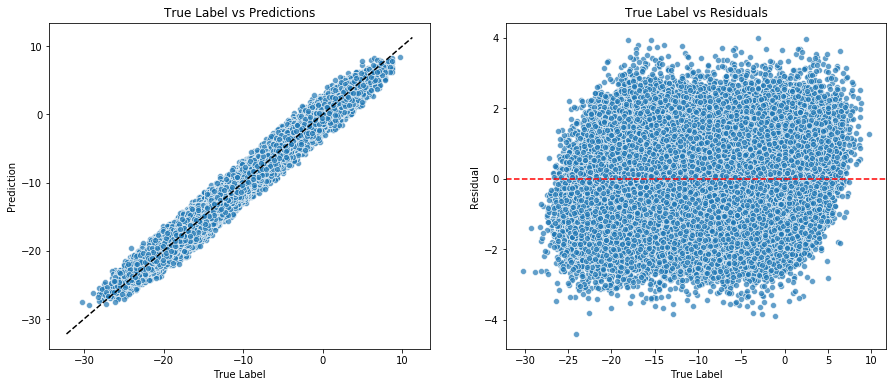

In [4]:
oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

However, we see that not necessarily we estimate the coefficients correctly

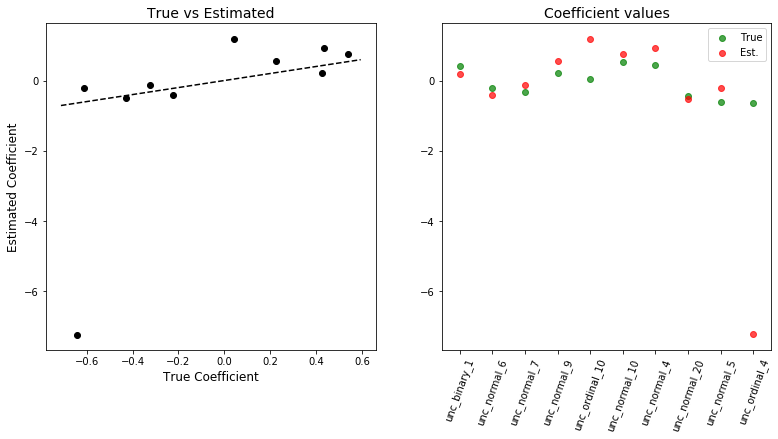

In [5]:
hyp.plot_coefficients('tar_lin_10', coefs_est)

In [6]:
res = make_results(label=target, prediction=oof, model='LinearRegression', 
                   parameters={'standard'}, 
                   target_name='tar_lin_10', variables='unc', instances=100000, verbose=True)

MAE: 		 0.79715
MSE: 		 0.99826
Max Error: 	 4.39629
Expl Variance: 	 0.98249


This is actually the effect of the scaler we used. The targets were not generated by first scaling the data and thus the true coefficients can be different.

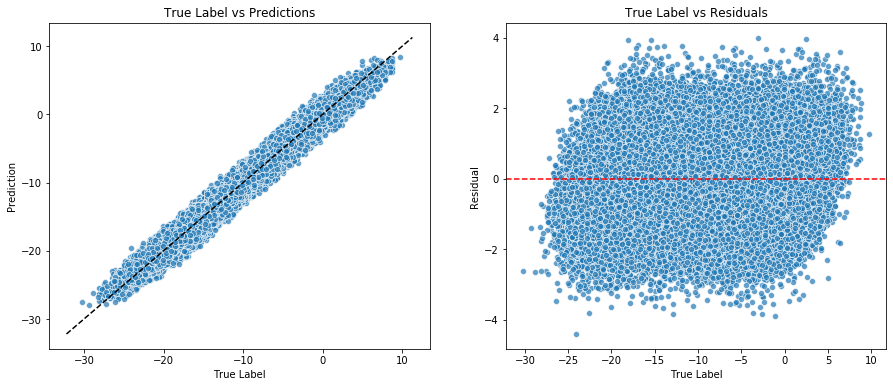

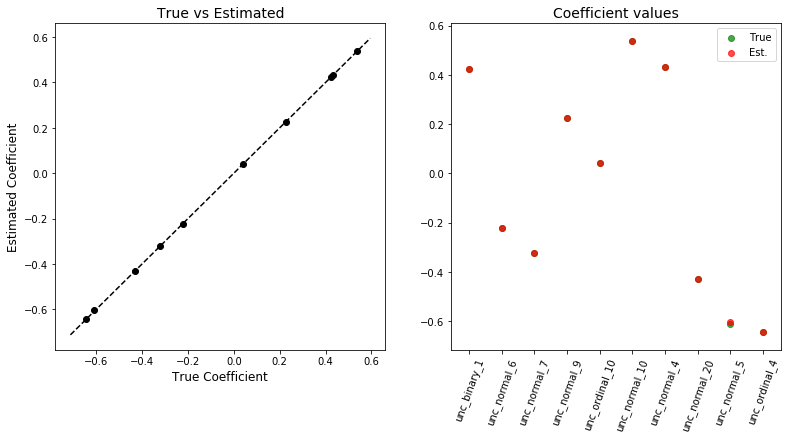

MAE: 		 0.79714
MSE: 		 0.99823
Max Error: 	 4.39341
Expl Variance: 	 0.98249


In [7]:
model = Pipeline([('processing', processing_pipe),
                  ('scl', df_p.dummify()),  # it does nothing, but guarantees that the other functions do not break
                  ('linear', LinearRegression())])

oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

hyp.plot_coefficients('tar_lin_10', coefs_est)

res = make_results(label=target, prediction=oof, model='LinearRegression', 
                   parameters={'standard'}, 
                   target_name='tar_lin_10', variables='unc', instances=100000, verbose=True)

On the other hand, we see that if the target is generated non-linearly, the model performs poorly

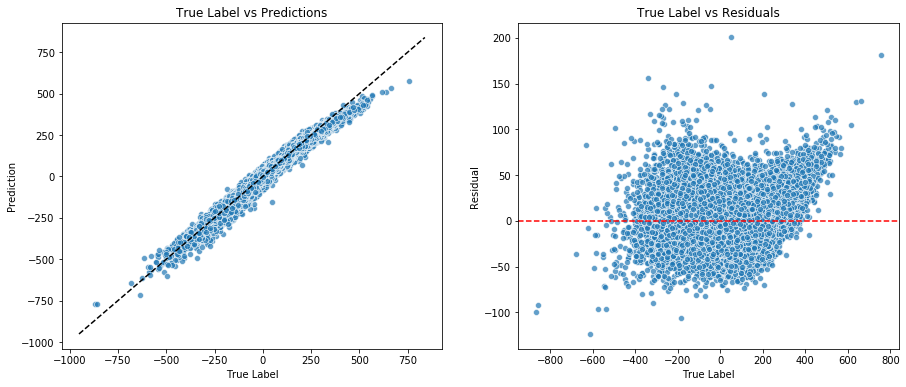

MAE: 		 12.68177
MSE: 		 297.82075
Max Error: 	 200.28833
Expl Variance: 	 0.97982


In [8]:
model = Pipeline([('processing', processing_pipe),
                  ('scl', df_p.df_scaler()),  # here we won't look at the coefficients, we can use the normal scaler
                  ('linear', LinearRegression())])

df_train = df[[col for col in df.columns if not col.startswith('tar_')]].copy()

target = df['tar_nonlin_10']

oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

res = make_results(label=target, prediction=oof, model='LinearRegression', 
                   parameters={'standard'}, 
                   target_name='tar_nonlin_10', variables='All', instances=100000, verbose=True)

For each model, we will have a look at these metrics and store the results when needed. We will iterate on different data and model configurations with the goal of understanding how all these moving parts are playing with one another.

## Side note on using scalers

The objective functions of linear models (especially with regularization) assumes that the features are centered around 0 and have roughly the same scale. Therefore, **the correct procedure is to always scale your features**. This makes also the interpretation of the coefficients possible since we are then allowed to say that the variation of one feature by one unit has the same interpretation across the features and thus we can say something about the coefficients. Moreover, scaling the features often speeds up the learning process of our algorithms.

All that being said, we want to explore how different algorithms react in different situations and one way to judge that is to check how well the coefficients are estimated. Therefore, we will make an exception and **not use any scaler** every time we want to check the estimate of the coefficients, compromising a bit the performance and accuracy of the models to allow ourselves to check this aspect as well.

# Experiments

## LinearRegression

We have seen already that if the target is linearly generated, we can perfectly fit the data (please keep in mind that all the predictions and the scores are referring to the performance on an holdout set with a 10 fold CV scheme). The model has very few hyperparameters ([see the sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)) and we thus investigate the performance of the model when we change the input data.

In [9]:
LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Linear functions, noise, correlation

In this section, we see how `LinearRegression` can fit data and predict a target variable generated by a linear relation.

First, we use a dataset of 100000 observations, 10 variables, all of which were used to generate the target without noise.

In [4]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('linear', LinearRegression())])
params = 'default'

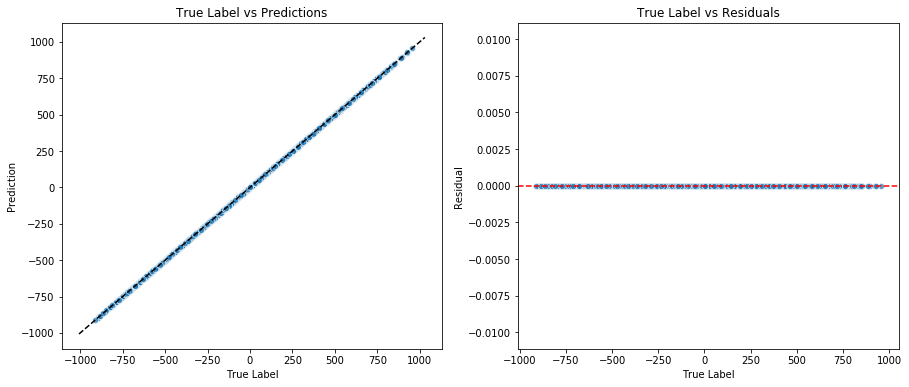

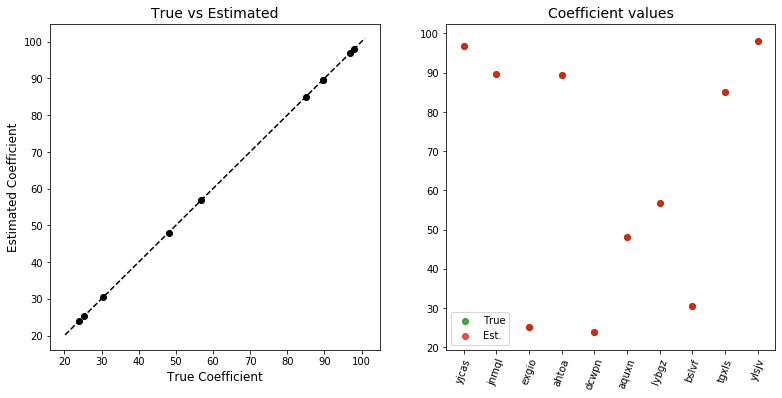

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


In [9]:
skl_exp(model=model, data_name='data/simulated/10_feat_10_inf_nonoise.csv', features='all', kfolds=kfolds,
        sample=False, store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

However, already using a target generated with some **noise** we notice a significant drop in performance

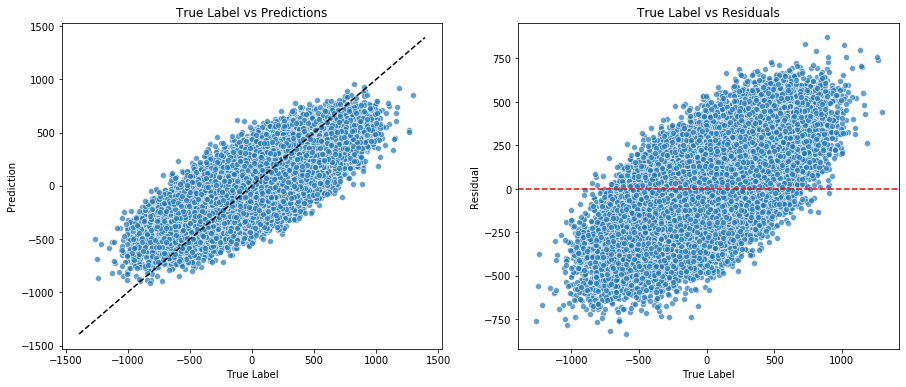

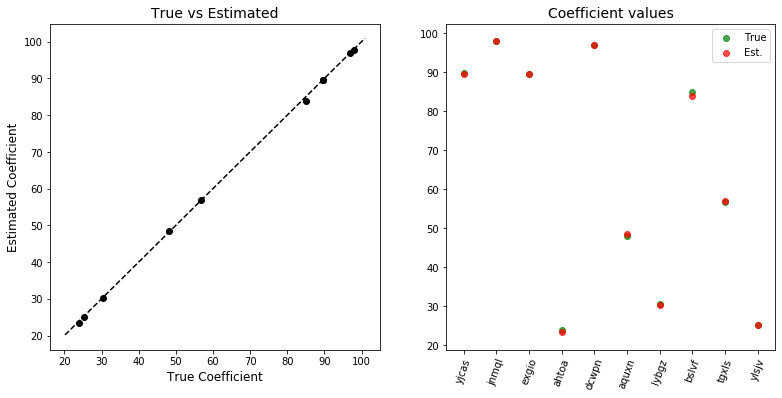

MAE: 		 159.15957
MSE: 		 39903.46378
Max Error: 	 870.78547
Expl Variance: 	 0.55337


In [14]:
skl_exp(model=model, data_name='data/simulated/10_feat_10_inf_noise.csv', features='all', kfolds=kfolds,
        sample=False, store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

Still a reasonably good estimation of the coefficients, something that deteriorates if we have more coefficients (for example, 65 informative features over 100 available)

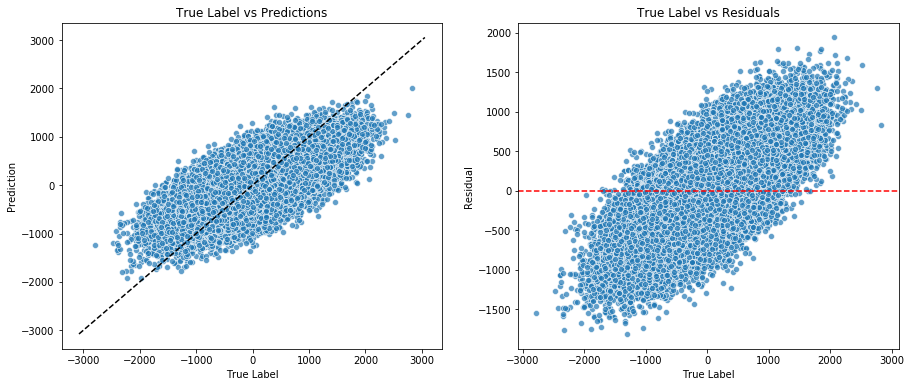

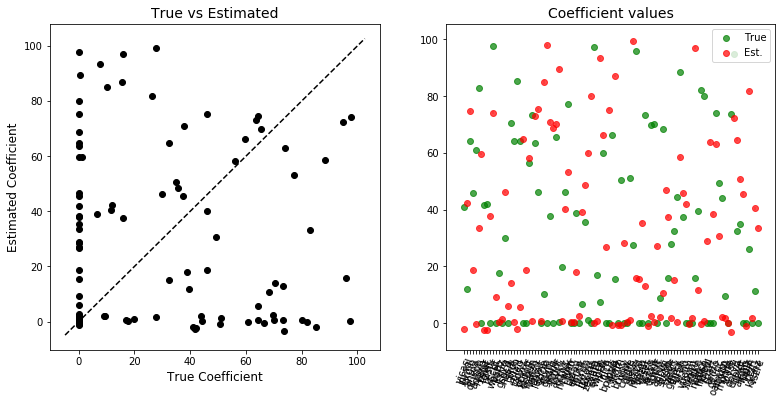

MAE: 		 359.51792
MSE: 		 202633.44246
Max Error: 	 1939.61267
Expl Variance: 	 0.48907


In [15]:
skl_exp(model=model, data_name='data/simulated/100_feat_65_inf_noise.csv', features='all', kfolds=kfolds,
        sample=False, store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

Curiously, if we introduce correlation among the features we get again reasonable estimates of the coefficients

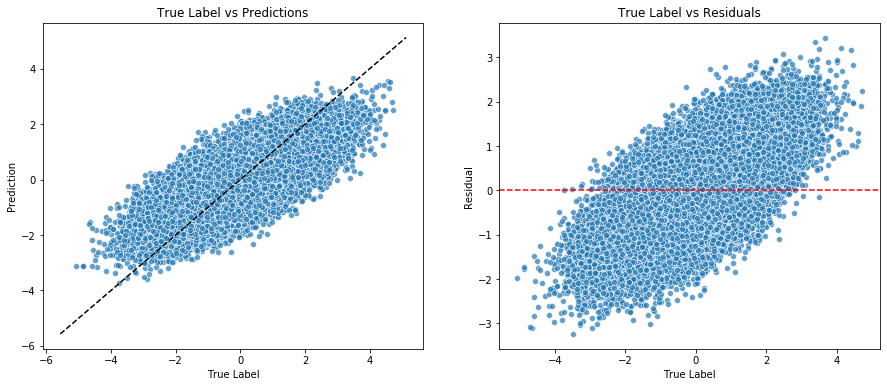

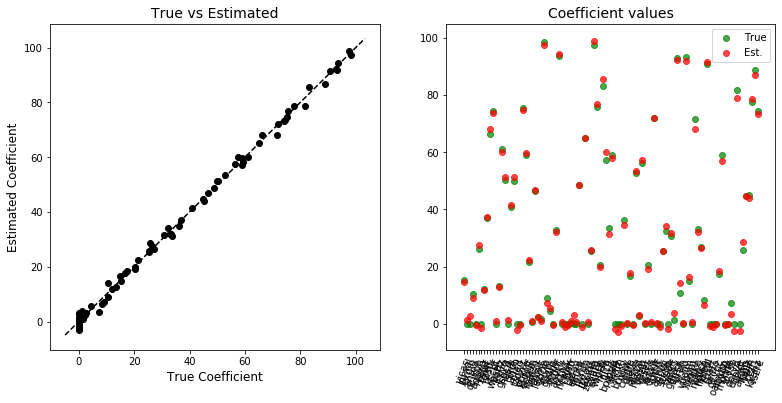

MAE: 		 0.63864
MSE: 		 0.63961
Max Error: 	 3.43738
Expl Variance: 	 0.53145


In [16]:
skl_exp(model=model, data_name='data/simulated/100_feat_65_inf_noise_rank.csv', features='all', kfolds=kfolds,
        sample=False, store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

### Number of instances

If we vary the number of features, we notice interesting patterns. For example, for how much the model is (reasonably) not able to pick up a signal if there is noise, it would get a very similar result by using much fewer training instances and, by using them all, it learns the underlying relation at the best of its possibilities (as we have seen from the perfectly estimated coefficients)

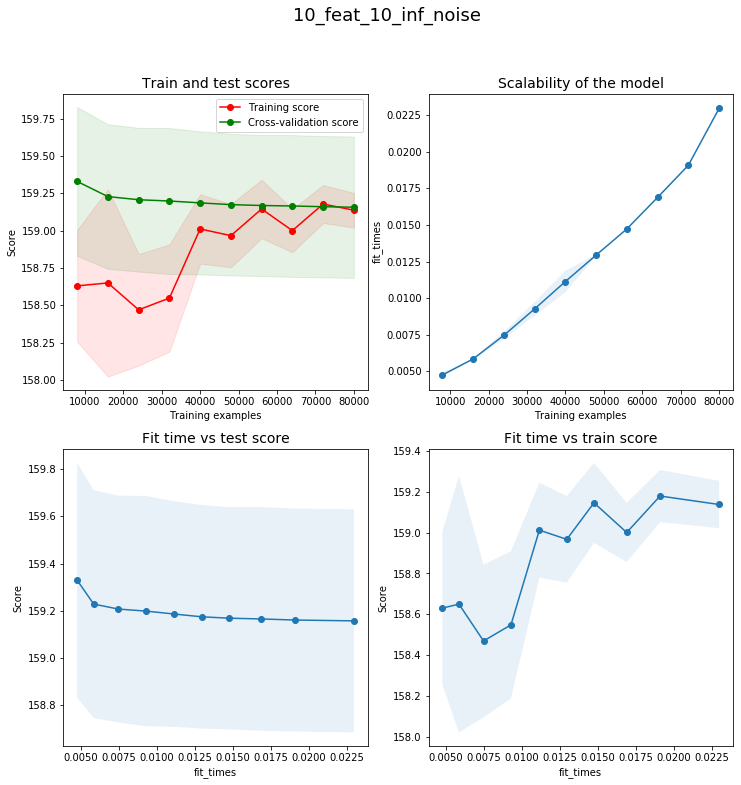

In [5]:
learning_curve(model=model, data_name='data/simulated/10_feat_10_inf_noise.csv')

As it is expected, if we have more features, the model benefits more from a higher number of training instances.

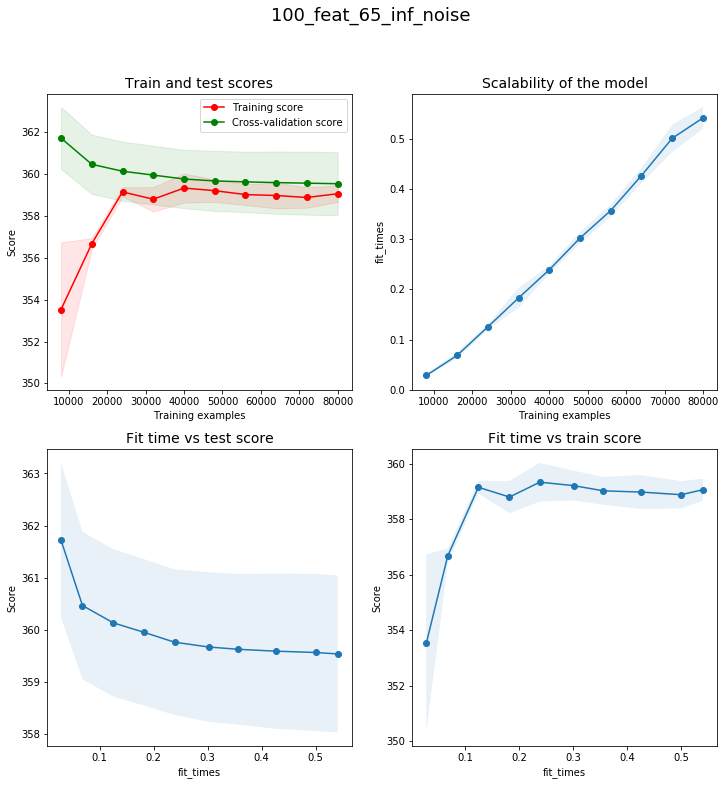

In [6]:
learning_curve(model=model, data_name='data/simulated/100_feat_65_inf_noise.csv')

We can then look at the results of our experiment if we limit the number of instances to a very low number and notice how the estimate of the coefficients, that was perfect before, deteriorates.

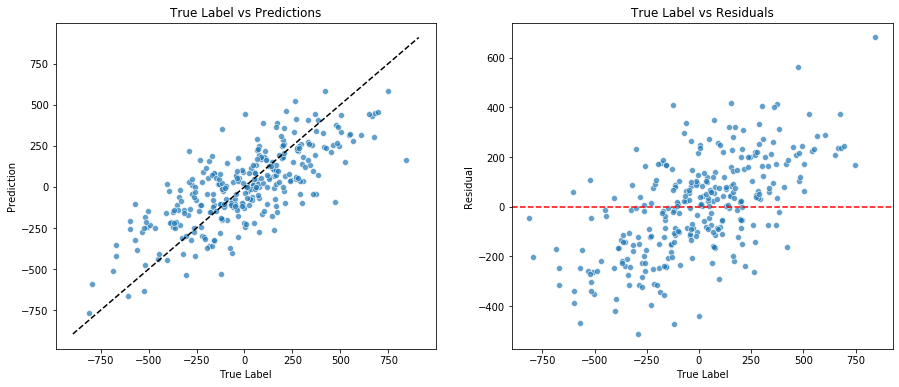

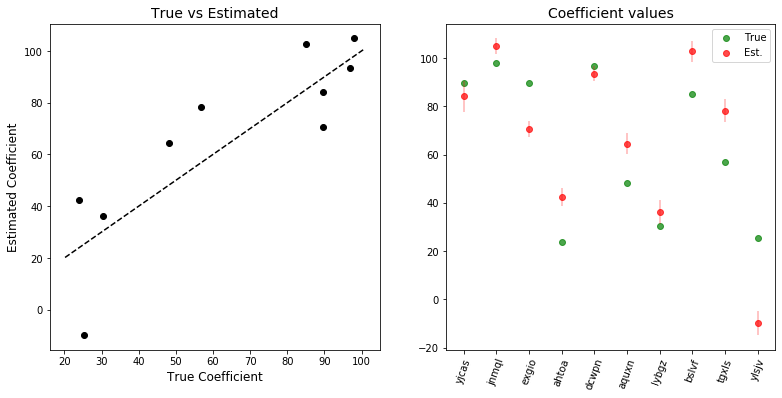

MAE: 		 156.84312
MSE: 		 38101.01906
Max Error: 	 681.28739
Expl Variance: 	 0.56447


In [7]:
skl_exp(model=model, data_name='data/simulated/10_feat_10_inf_noise.csv', features='all', kfolds=kfolds,
        sample=300, store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

### Good performance, bad coefficients

We have seen before that we can have a model that perfectly fits the data but estimates poorly the coefficients. Let's see how is this possible.

To do so, let's take dataset without noise where the target was generated by a fraction of the total available features. Even though the prediction is perfect, the model is setting to 0 a lot of coefficients that are not supposed to be 0, and giving non-null value to many other variables. In other words, a linear combination of variables can potentially substitute the effect that another variable is having on the target.

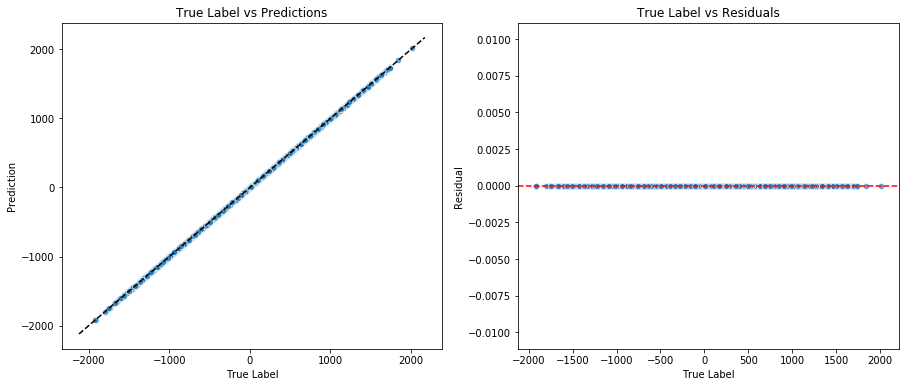

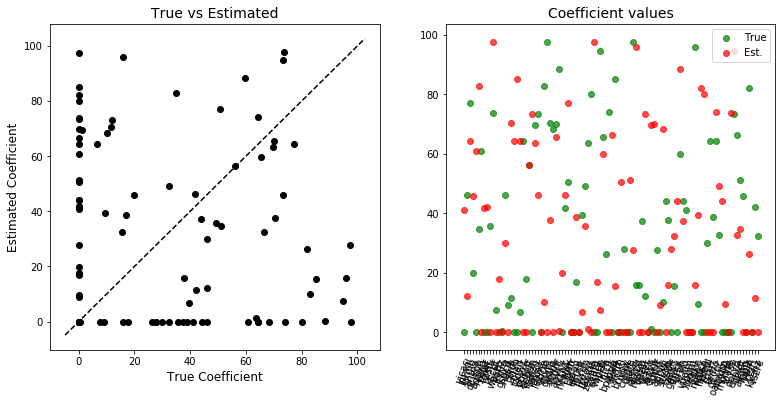

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


In [18]:
skl_exp(model=model, data_name='data/simulated/100_feat_65_inf_nonoise.csv', features='all', kfolds=kfolds,
        sample=False, store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

Interestingly enough, if we restrict the training variables to the one that were actually used to generate the model, we still get the perfect score but not a better estimate for each coefficient, showing that the model is already struggling with picking up the signal of each feature.

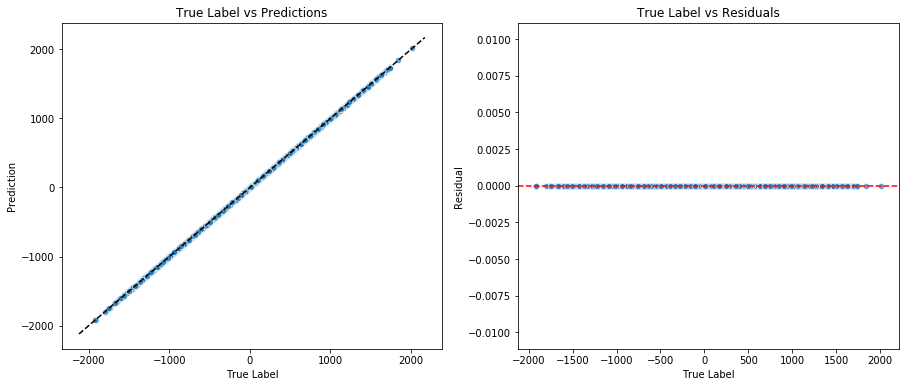

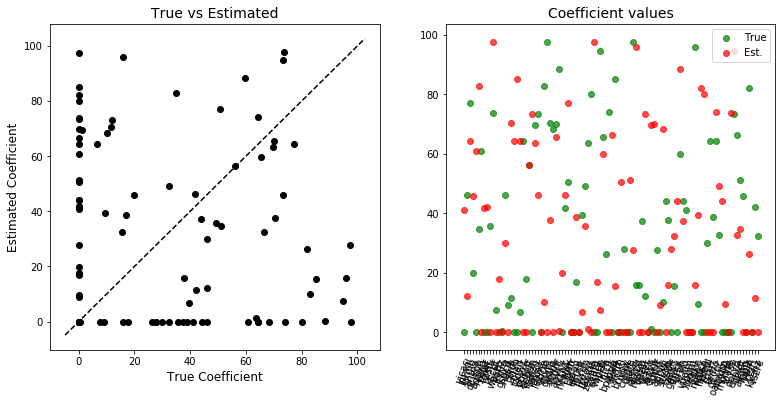

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


In [19]:
skl_exp(model=model, data_name='data/simulated/100_feat_65_inf_nonoise.csv', features='exact', kfolds=kfolds,
        sample=False, store=True, coefs=True, store_name=lab_book, parameters=params, model_name='LinearRegression')

### More complex datasets

Since the dataset generated by sklearn can be either too complicated or too simple for our experiments, we can test our algorithm on the data we generated in notebook 1.

In [9]:
def experiment_lr(target_name, features, kfolds, store=False, sample=False):
    df = pd.read_csv('data/simulated/clean.csv')
    if sample:
        df = df.sample(sample)
    
    coefficients = pd.read_pickle('data/simulated/coefficients.pkl')
    coef_names = list(coefficients[target_name].feat.values)

    target = df[target_name]
    
    df = pd.get_dummies(df, drop_first=True)
    
    df_train = select_features(features, df, target_name, coef_names)
    
    model = Pipeline([('imputer', df_p.df_imputer()),
                      ('linear', LinearRegression())])

    oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

    plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

    hyp.plot_coefficients(target_name, coefs_est)
    
    if store:
        store_results('data/03_linear_models.csv', 
                      label=target, prediction=oof, model='LinearRegression', 
                      parameters={'Irrelavant'}, 
                      target_name=target_name, variables=features, instances=df_train.shape[0], verbose=True)
    else:
        res = make_results(label=target, prediction=oof, model='LinearRegression', 
                           parameters={'Irrelavant'}, 
                           target_name=target_name, variables=features, instances=df_train.shape[0], verbose=True)
        

We start with a target created by a linear combination of all **100 features** and we provide a dataset that contains them all. We expect a dependency with the numbert of training instances.

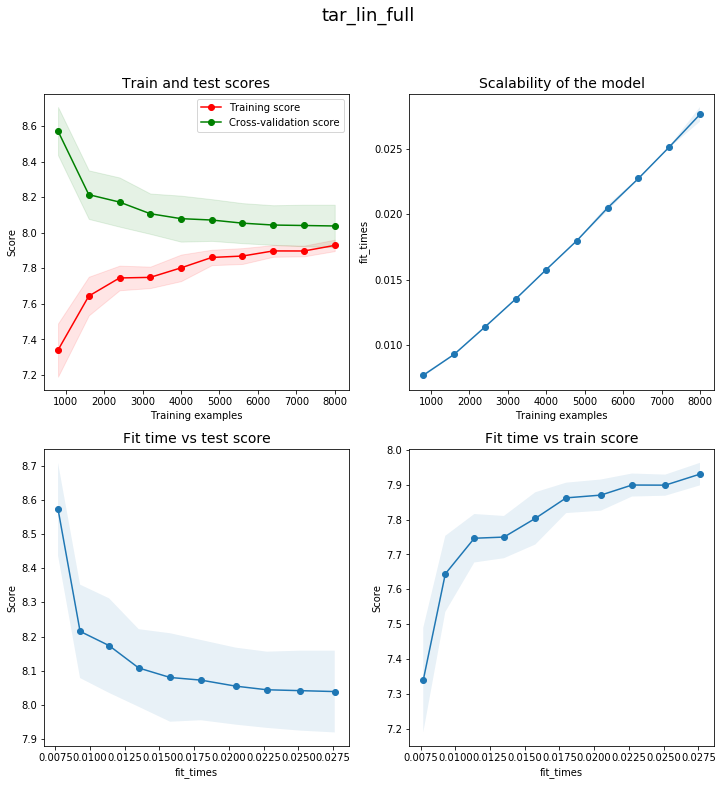

In [8]:
learning_curve(model, target_name='tar_lin_full', features='all', sample=10000)

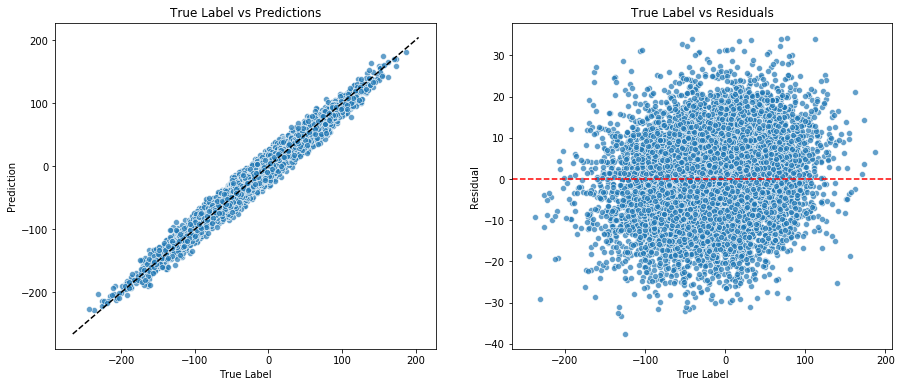

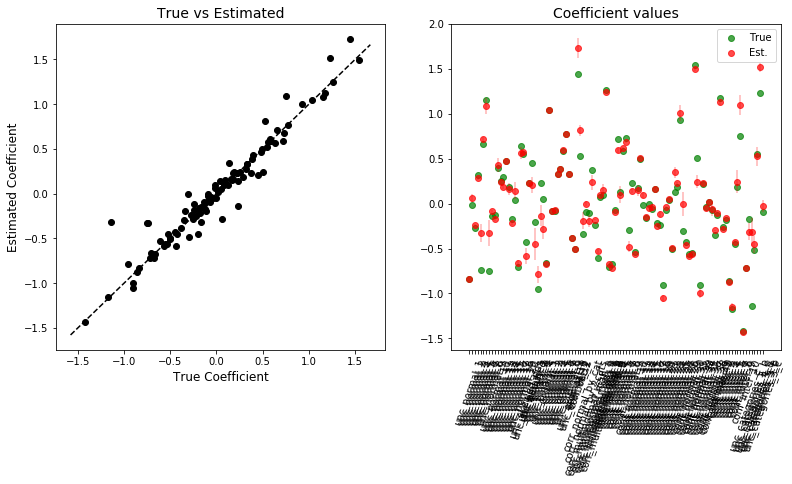

MAE: 		 7.95248
MSE: 		 99.46816
Max Error: 	 37.60624
Expl Variance: 	 0.97037


In [59]:
experiment_lr(target_name='tar_lin_full', features='all', kfolds=kfolds, store=True, sample=10000)

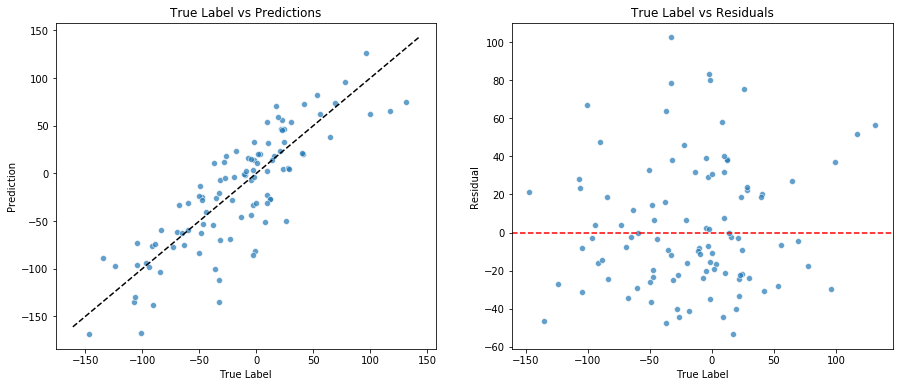

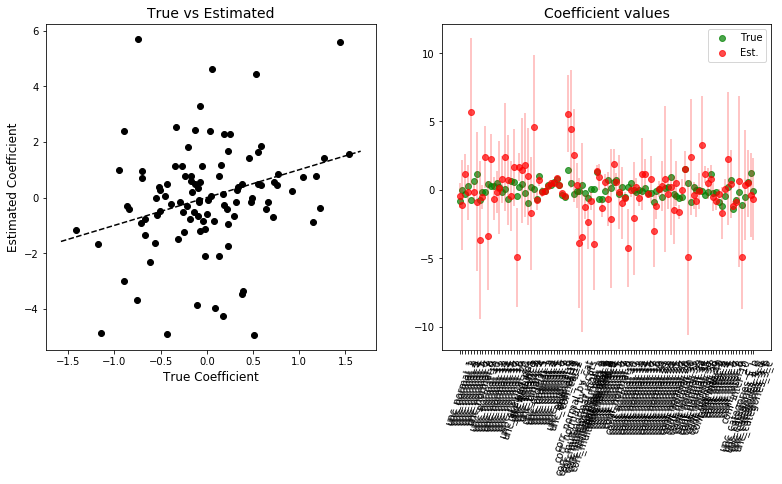

MAE: 		 27.02999
MSE: 		 1137.53493
Max Error: 	 102.55641
Expl Variance: 	 0.60862


In [60]:
experiment_lr(target_name='tar_lin_full', features='all', kfolds=kfolds, store=True, sample=100)

With very few training instances the model is struggling quite a lot. We also observe that, even though the score can get better with more observations, the estimate of the coefficients is not accurate for some coefficients.

In alternative, we can simulate what would happen if we don't have all the features used to generate the target (thus if there is some unobserved variable)

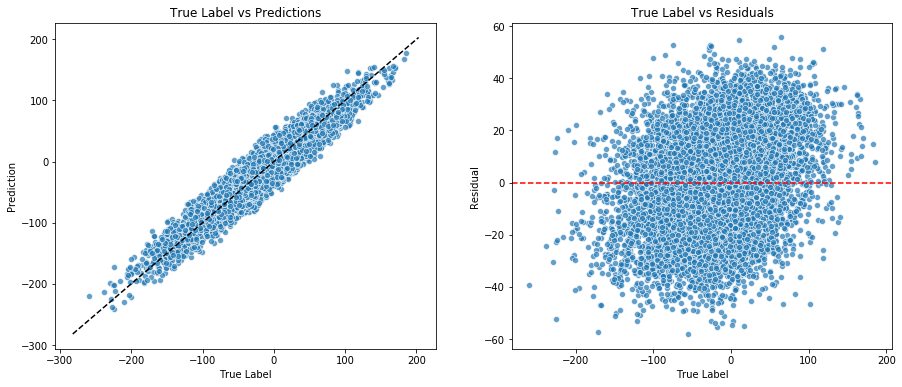

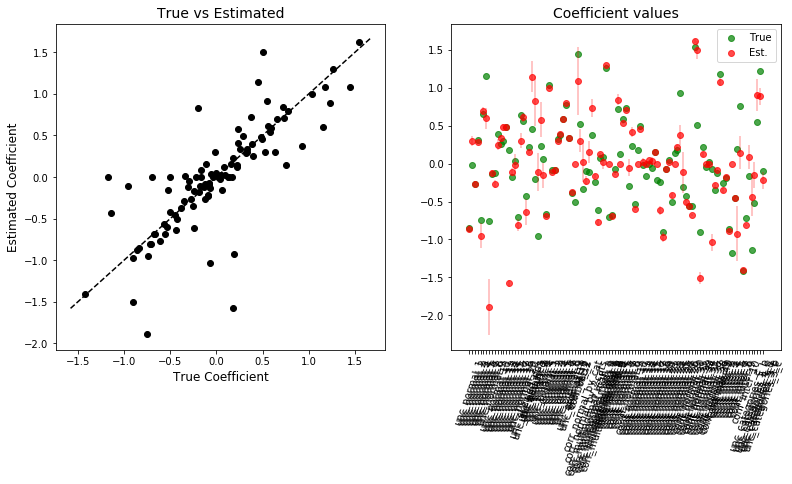

MAE: 		 15.53328
MSE: 		 356.3456
Max Error: 	 58.0803
Expl Variance: 	 0.89405


In [85]:
experiment_lr(target_name='tar_lin_full', features='unobserved', kfolds=kfolds, store=True, sample=10000)

The coefficient plot fills the missing coefficients with a value of 0, therefore we can compare the estimates using all the features and only 90% of them and notice that some of the 'unobserved' ones happen to have a negative coefficients. We see those anomalous 3 dots in the mid left of the first coefficient plot. We can then see how the rest of the coefficients adapted to compensate.

We then see that this random 10% of unobserved variables led to a nearly doubled absolute error, much higher maximum error, and a drop of 8% in the explained variance.

We can now simulate what would happens with a target generated by **50 features**. Here it might be interesting to see the dependency from the number of instances both if we just use the right 50 features or we use 50 additional useless features (but keep in mind that some of these additional features are interactions of the first 50).

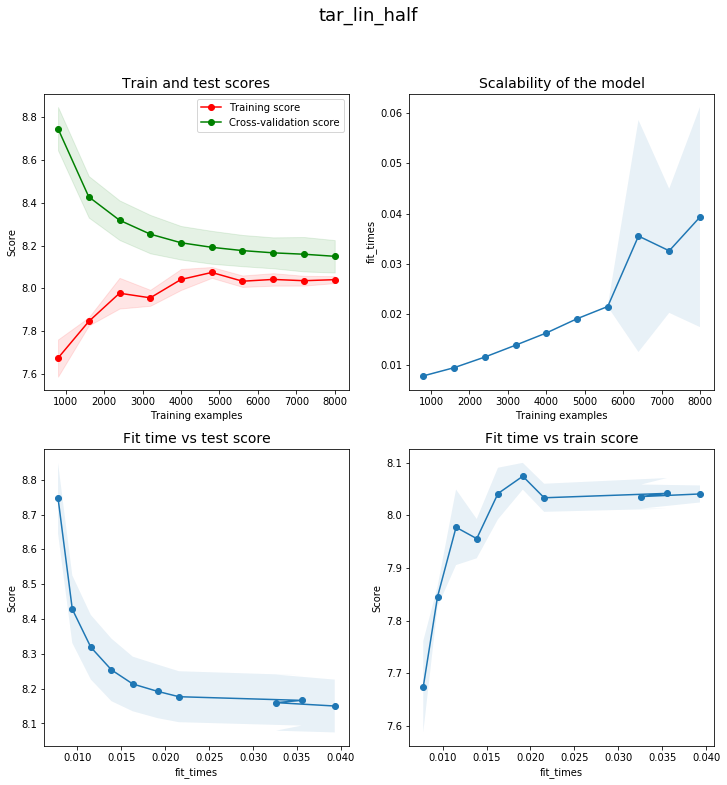

In [69]:
lr_learning_curve('tar_lin_half', 'all', sample=10000)

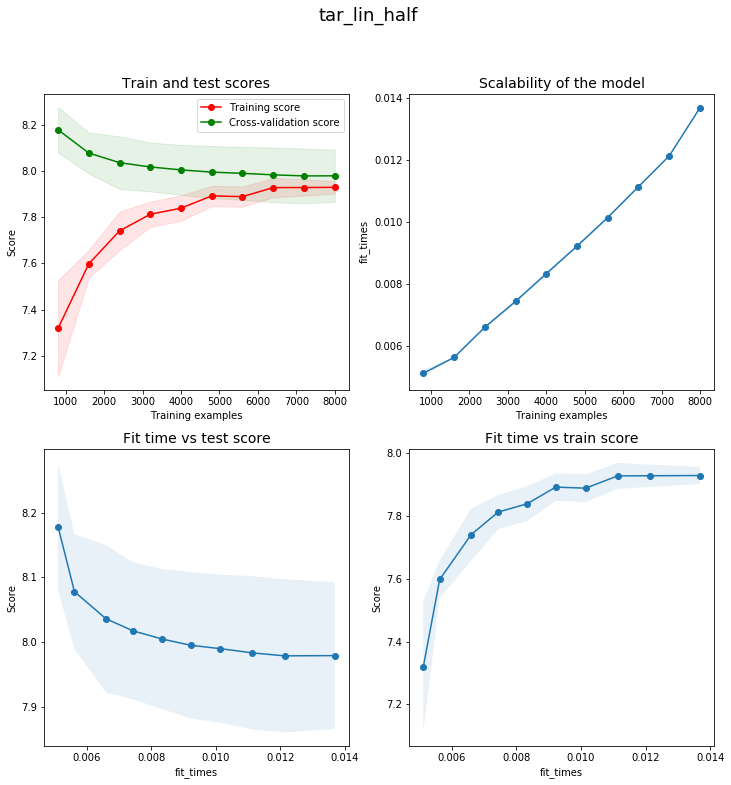

In [68]:
lr_learning_curve('tar_lin_half', 'exact', sample=10000)

We see that the scalability of the model does not change, but the one using fewer featurs is obviously faster. We also see that the model with all the features would benefit from additional data while the other one is already close to the best score it can achieve.

As a baseline, let's first see how the model learns when it trains with the exact features used to generate the target.

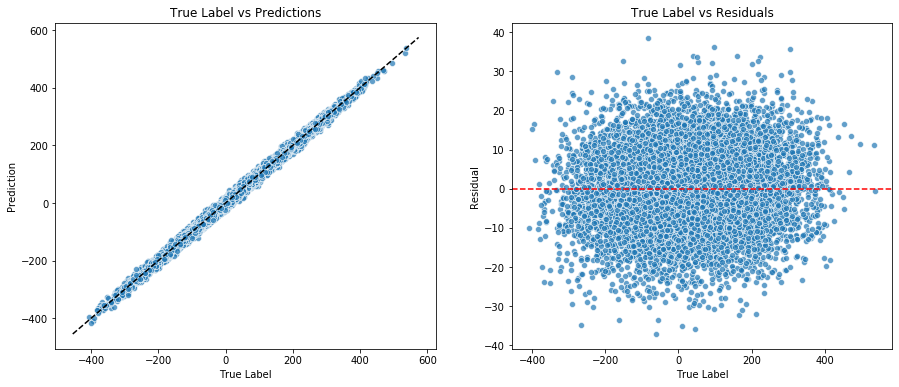

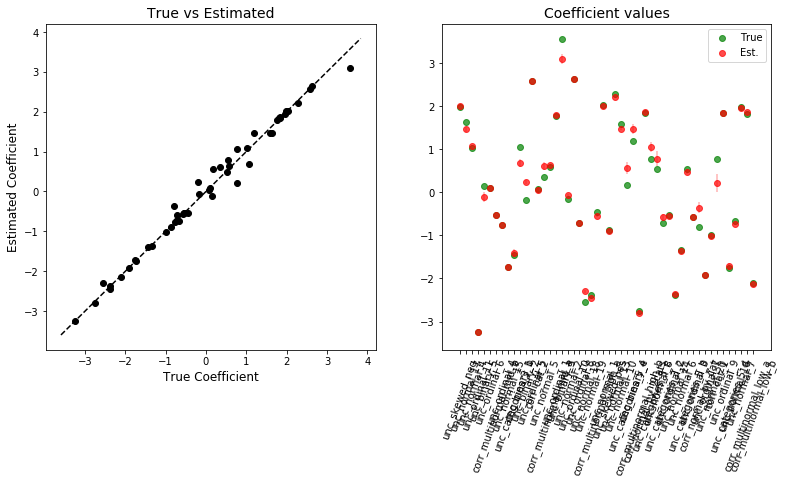

MAE: 		 7.9896
MSE: 		 100.0797
Max Error: 	 38.64084
Expl Variance: 	 0.99553


In [71]:
experiment_lr(target_name='tar_lin_half', features='exact', kfolds=kfolds, store=True, sample=10000)

It is a very good model, most of the 50 coefficients are estimated correctly with very little variance from fold to fold and the predictions look very nice. By using all the 100k observations, we get very similar scores and better coefficients' estimates.

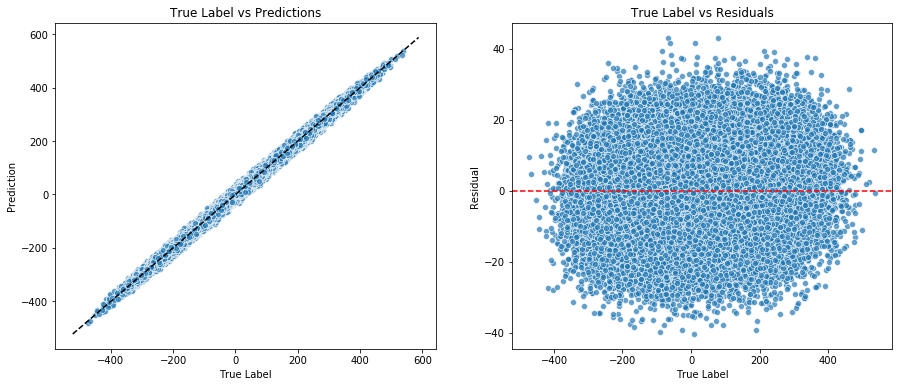

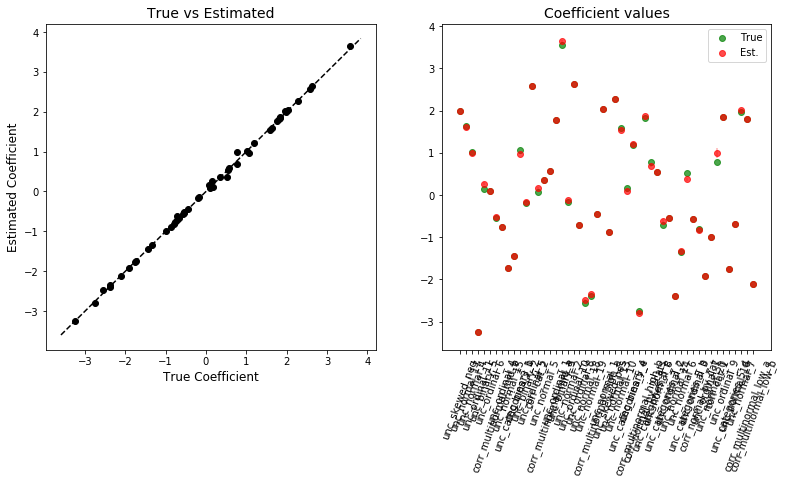

MAE: 		 7.99958
MSE: 		 100.44551
Max Error: 	 43.16594
Expl Variance: 	 0.99541


In [72]:
experiment_lr(target_name='tar_lin_half', features='exact', kfolds=kfolds, store=False, sample=100000)

On the other hand, with a very small number of features we see a significant drop in perfomance

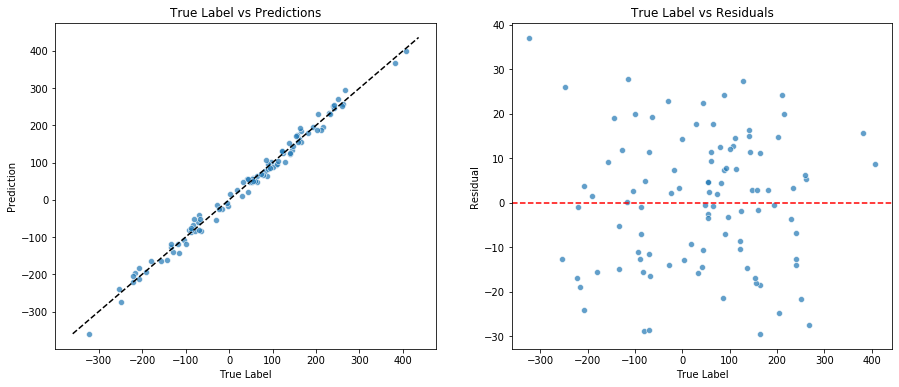

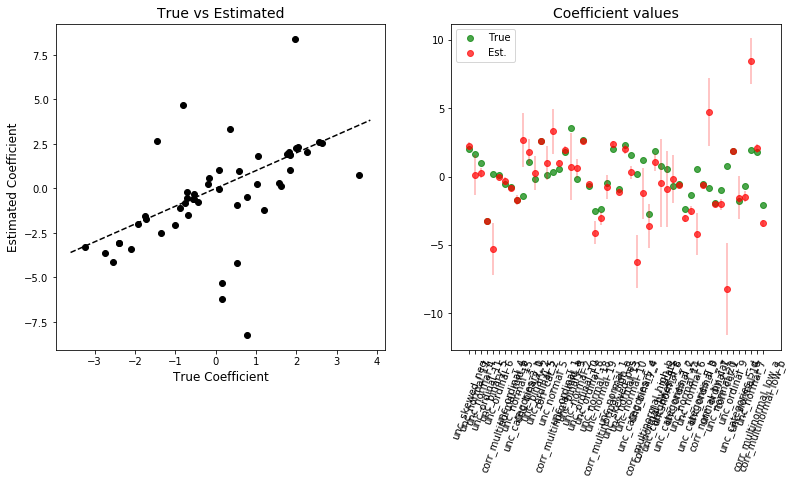

MAE: 		 12.16254
MSE: 		 216.38346
Max Error: 	 37.11051
Expl Variance: 	 0.99012


In [75]:
experiment_lr(target_name='tar_lin_half', features='exact', kfolds=kfolds, store=True, sample=100)

What happens then when we have more features. We expect the model to pick up the wrong signal more easily, thus a drop in perfomance and coefficients' estimate.

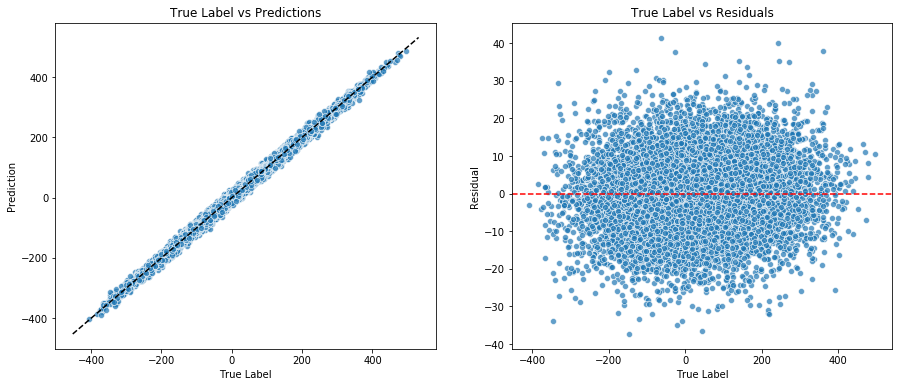

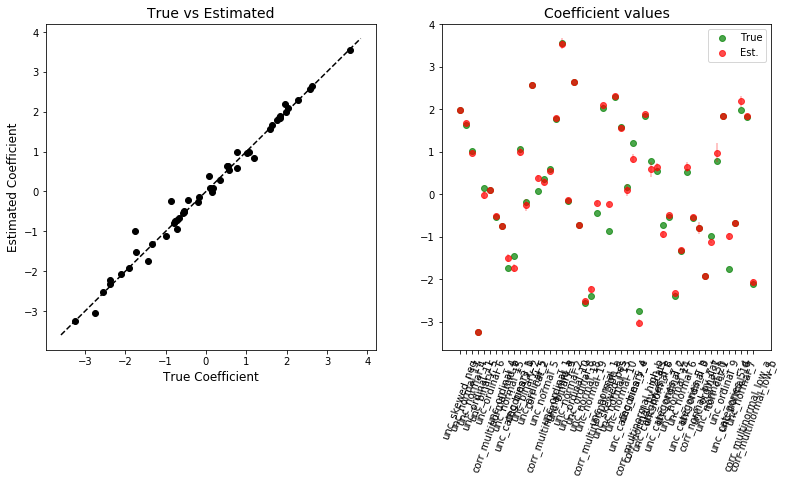

MAE: 		 7.97978
MSE: 		 100.80486
Max Error: 	 41.49069
Expl Variance: 	 0.99529


In [77]:
experiment_lr(target_name='tar_lin_half', features='all', kfolds=kfolds, store=True, sample=10000)

The performance doesn't drop much and the estimated coefficients are very similar to the previous ones, although less precise as expected. However, with only 100 training instances, the perfomance gets much worse, telling use that, if we have the right features, having more training instances is more important than feature selection.

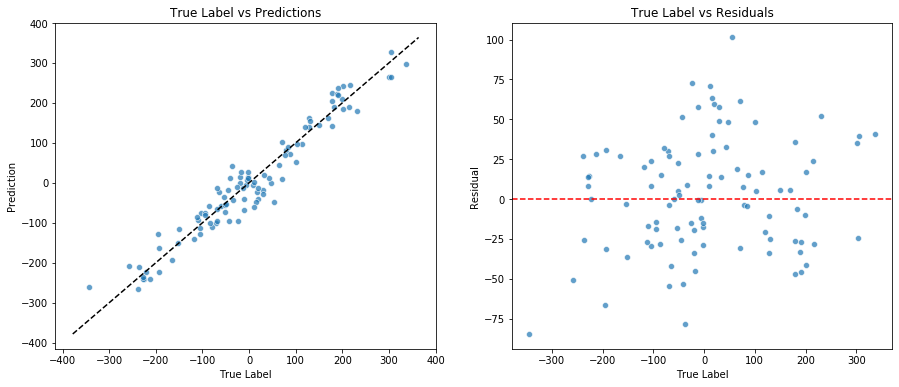

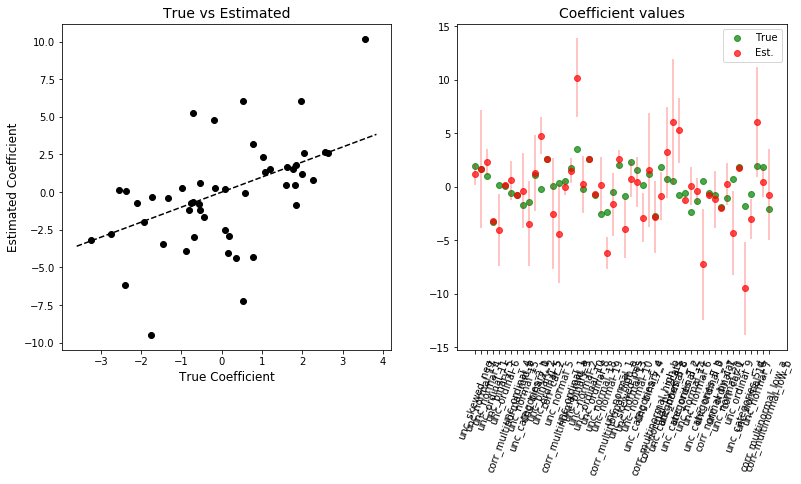

MAE: 		 28.89003
MSE: 		 1254.50971
Max Error: 	 101.33765
Expl Variance: 	 0.93715


In [80]:
experiment_lr(target_name='tar_lin_half', features='all', kfolds=kfolds, store=True, sample=100)

Once again, we can simulate the presence of unobserved variables. This time we can do so both with and without the presence of other variables unrelated to the target.

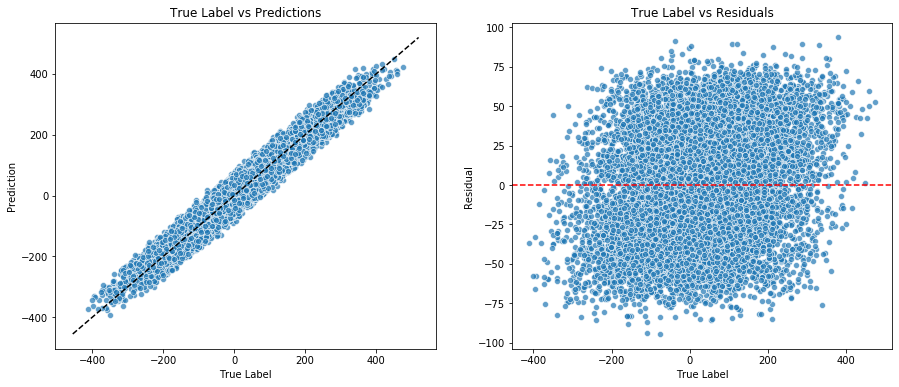

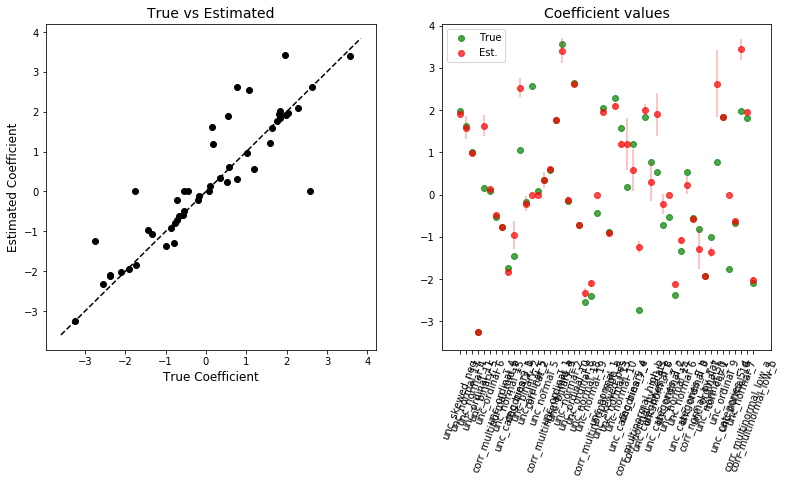

MAE: 		 32.14572
MSE: 		 1413.97348
Max Error: 	 94.50921
Expl Variance: 	 0.9342


In [82]:
experiment_lr(target_name='tar_lin_half', features='exact-10', kfolds=kfolds, store=True, sample=10000)

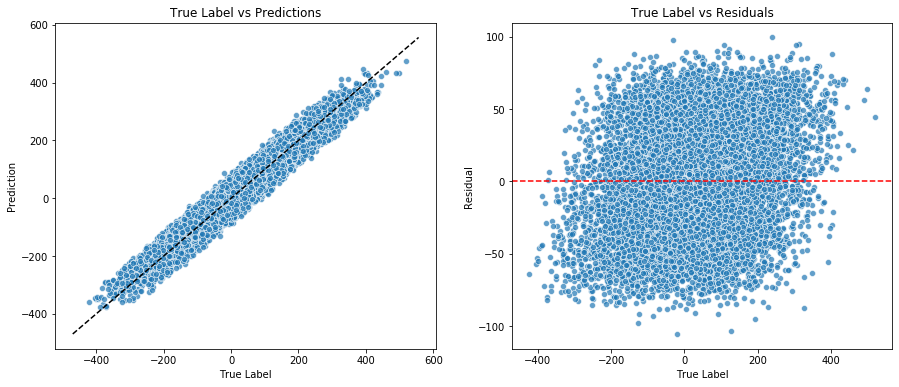

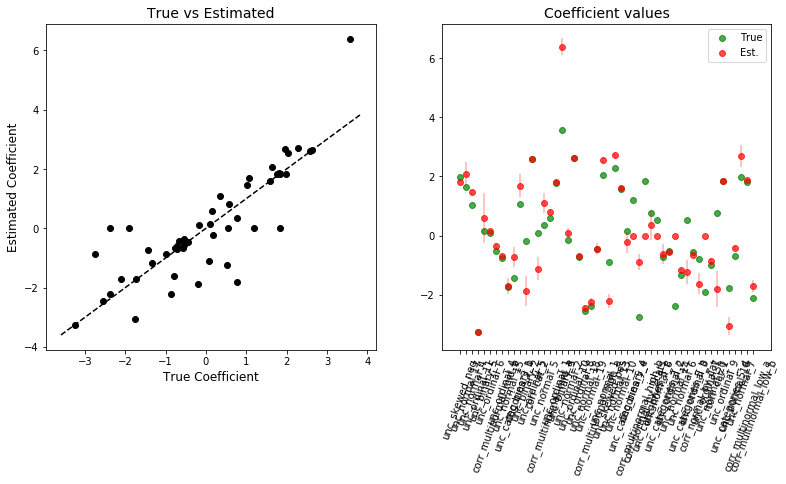

MAE: 		 34.35291
MSE: 		 1609.35844
Max Error: 	 105.48653
Expl Variance: 	 0.92738


In [84]:
experiment_lr(target_name='tar_lin_half', features='unobserved', kfolds=kfolds, store=True, sample=10000)

We see how dropping only 5 features is enough for the model to be compromised and how the effect of adding extra features is bigger.

We can now turn our attention to a situation where only a few features are really useful to predict the target. In particular, the next experiments will deal with a target generated by a linear combination of **10 features**. Again, let's use exactly the right features to get a baseline.

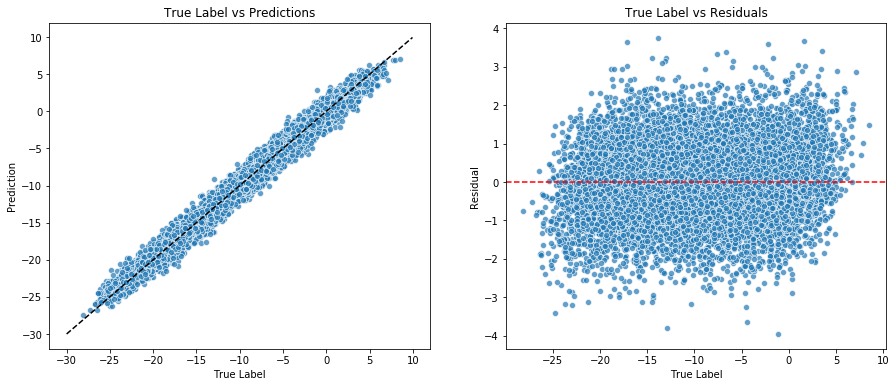

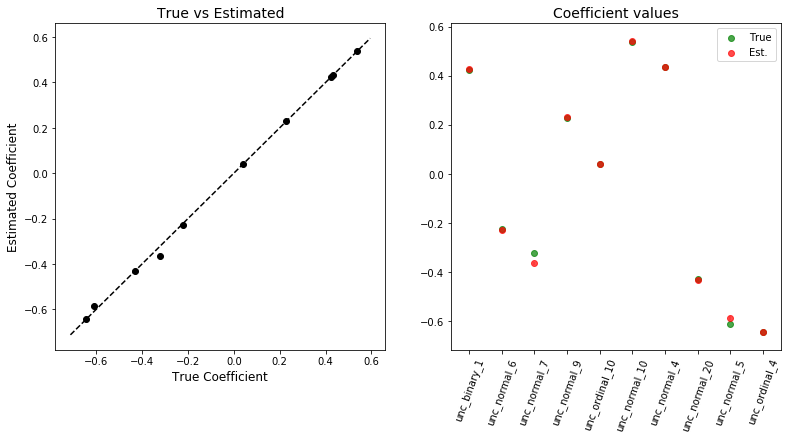

MAE: 		 0.79842
MSE: 		 1.00394
Max Error: 	 3.94521
Expl Variance: 	 0.98224


In [20]:
experiment_lr(target_name='tar_lin_10', features='exact', kfolds=kfolds, store=True, sample=10000)

We see some imprecisions in the coefficient estimates that gets even bigger if we reduce the number of instances.

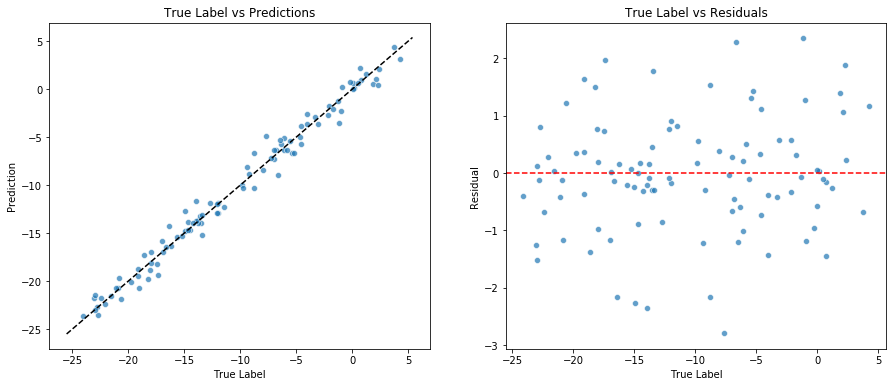

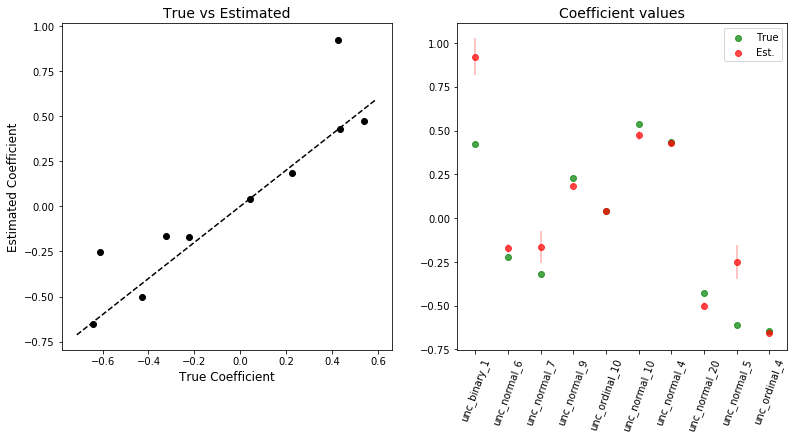

MAE: 		 0.75782
MSE: 		 1.01313
Max Error: 	 2.79802
Expl Variance: 	 0.98328


In [21]:
experiment_lr(target_name='tar_lin_10', features='exact', kfolds=kfolds, store=True, sample=100)

But completely disappears if we use all 100k available observations.

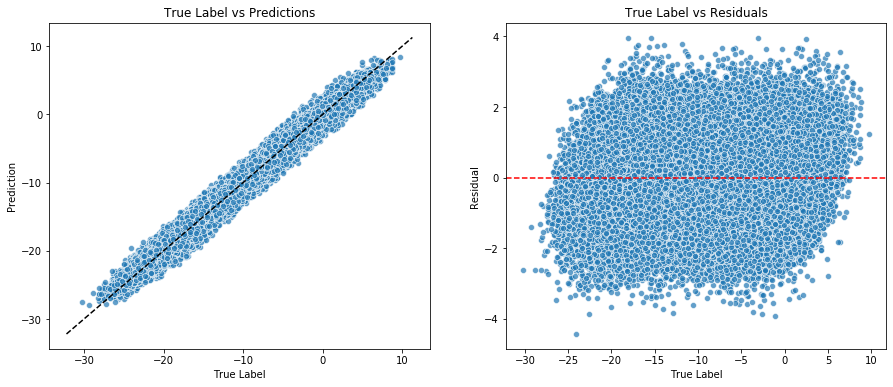

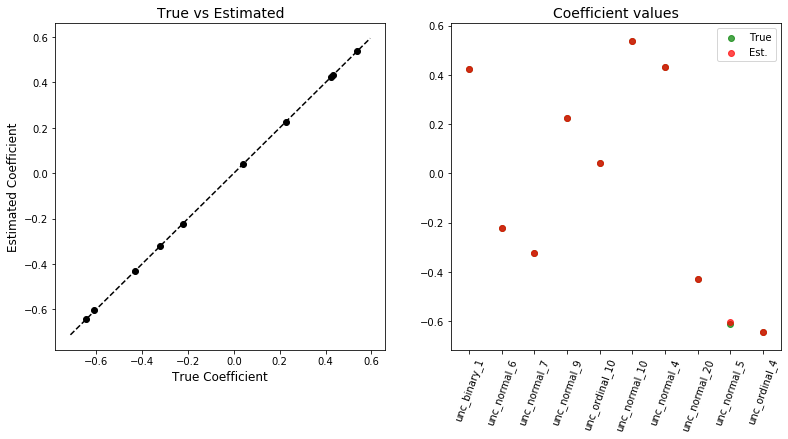

MAE: 		 0.797
MSE: 		 0.99785
Max Error: 	 4.42169
Expl Variance: 	 0.98249


In [22]:
experiment_lr(target_name='tar_lin_10', features='exact', kfolds=kfolds, store=False, sample=100000)

If we then allow the model to train on all the available features, we get

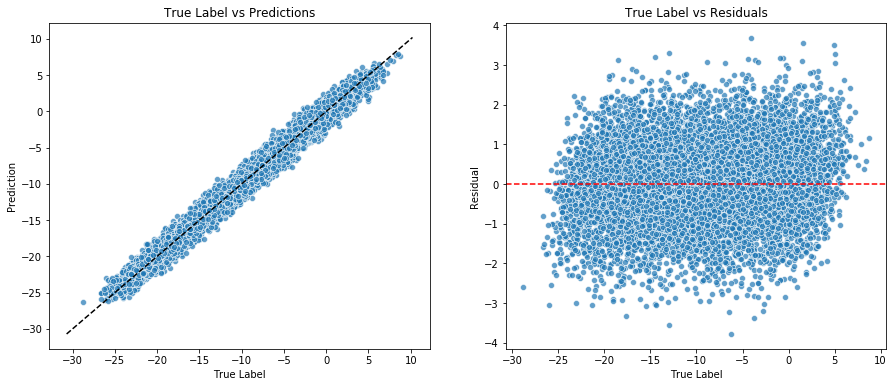

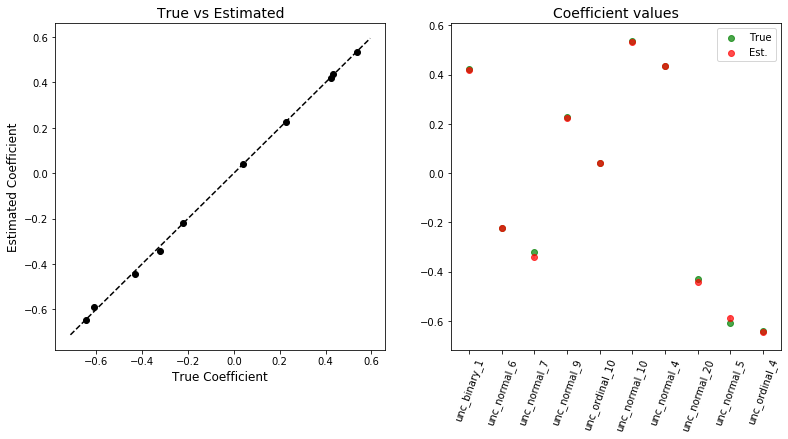

MAE: 		 0.80307
MSE: 		 1.01131
Max Error: 	 3.76651
Expl Variance: 	 0.98249


In [24]:
experiment_lr(target_name='tar_lin_10', features='all', kfolds=kfolds, store=True, sample=10000)

We see again that the model is fundamentally behaving in the same way, even estimating the coefficients better. It is good to keep in mind that the plot shows only the true coefficients that were used to generate the target, not all the coefficients the model has. Some (more or less) accidental correlation with other features evidently made the estimate more accurate.

If instead of having more features than necessary, we have fewer, we get to the following two situations.

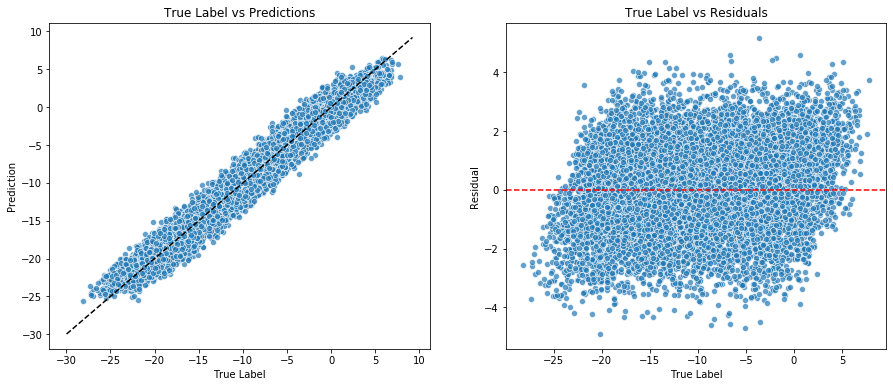

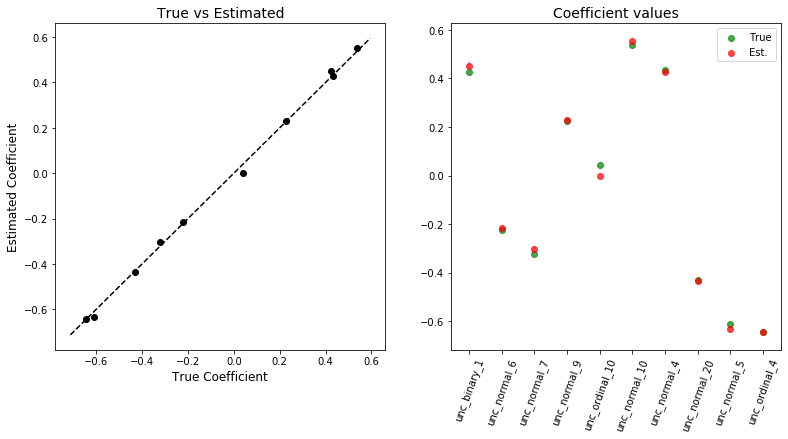

MAE: 		 1.27175
MSE: 		 2.39747
Max Error: 	 5.18297
Expl Variance: 	 0.95839


In [26]:
experiment_lr(target_name='tar_lin_10', features='exact-10', kfolds=kfolds, store=True, sample=10000)

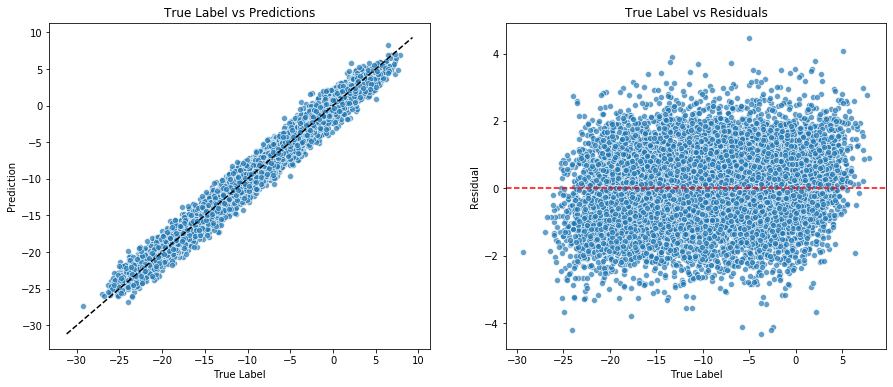

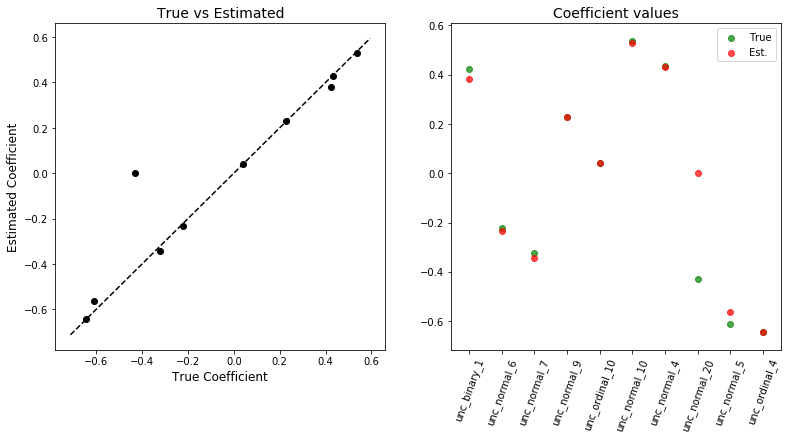

MAE: 		 0.90093
MSE: 		 1.2663
Max Error: 	 4.46785
Expl Variance: 	 0.97779


In [28]:
experiment_lr(target_name='tar_lin_10', features='unobserved', kfolds=kfolds, store=True, sample=10000)

The model again has a worse performance but this time we see that the effects of losing 10% of the available features (i.e. 1 feature) were much smaller than the previous examples.

At last, we can test the Linear Regression against something that is not supposed to be predicted via linear regression: a target generated by a **non-linear combination** of features.

As the coefficients (see notebook 1) are related to features that have different names in the data, we won't be able to study what happens with only the right features. The only option is to have them all for now.

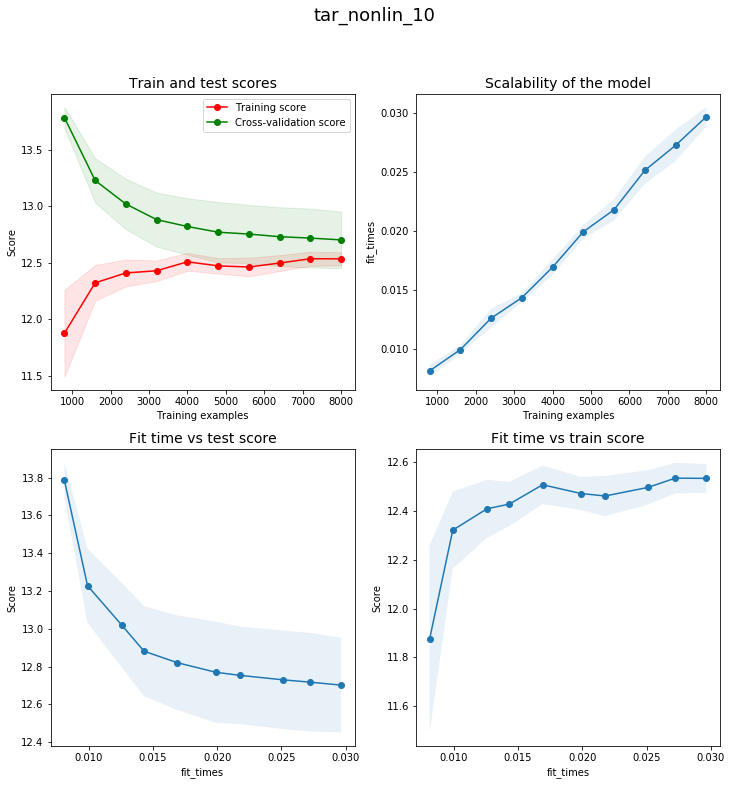

In [29]:
lr_learning_curve('tar_nonlin_10', 'all', sample=10000)

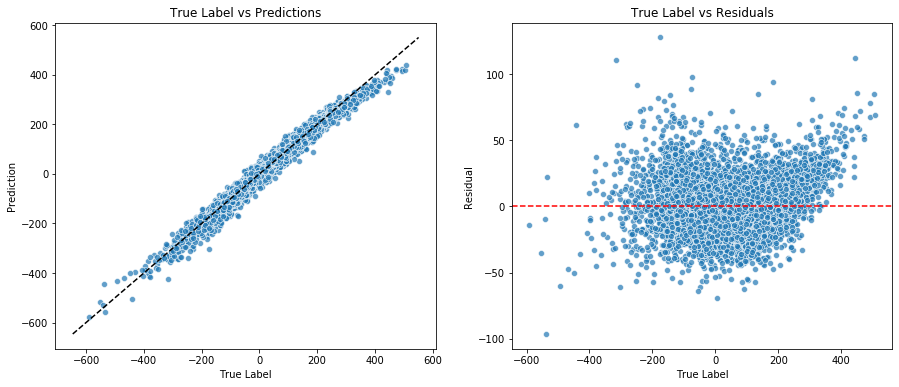

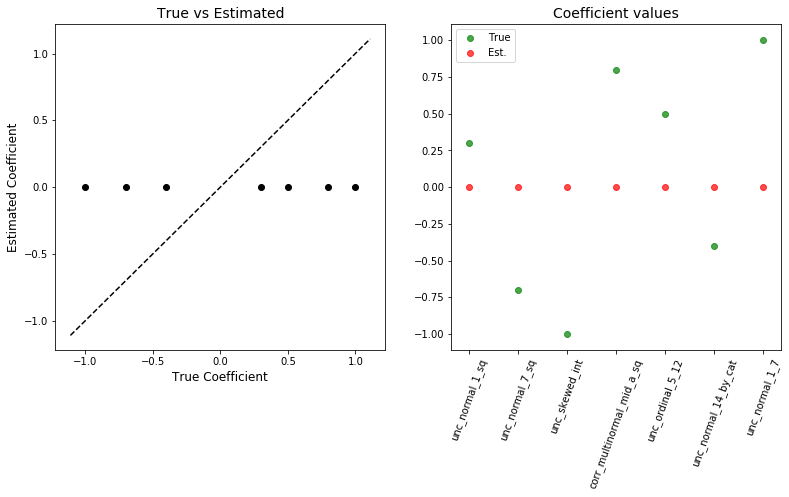

MAE: 		 12.73102
MSE: 		 298.40058
Max Error: 	 127.67194
Expl Variance: 	 0.98009


In [30]:
experiment_lr(target_name='tar_nonlin_10', features='all', kfolds=kfolds, store=False, sample=10000)

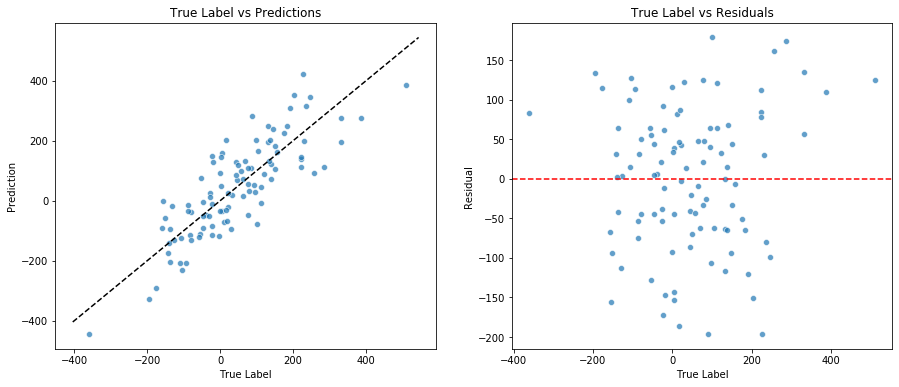

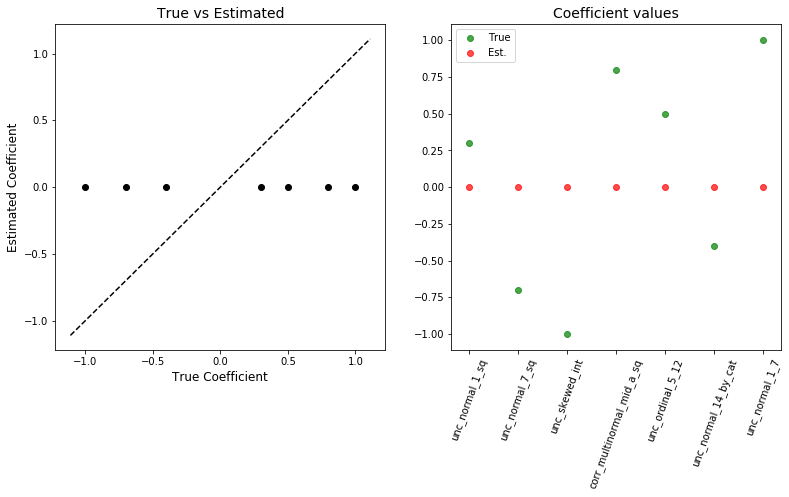

MAE: 		 74.97068
MSE: 		 8063.13453
Max Error: 	 196.15707
Expl Variance: 	 0.58163


In [31]:
experiment_lr(target_name='tar_nonlin_10', features='all', kfolds=kfolds, store=False, sample=100)

# Real application - HousePrice

# Conclusion